# Analysis of Ergodicity in the Double Pendulum Simulations


In [2]:
import numpy as np
from pathlib import Path

folder = Path("./paths2")

arrays = []   # list of (theta1, theta2) arrays

for csv_file in sorted(folder.glob("*.csv")):
    data = np.loadtxt(csv_file, delimiter=",", skiprows=1)  # skip header if present
    arrays.append(data)

print(f"Loaded {len(arrays)} CSV files.")


Loaded 1000 CSV files.


## Comparison of the original thetas

In [3]:
theta1_means = [np.mean(traj[:, 0]) for traj in arrays] 
theta2_means = [np.mean(traj[:, 2]) for traj in arrays]

theta1_all = np.concatenate([traj[:, 0] for traj in arrays])
theta2_all = np.concatenate([traj[:, 2] for traj in arrays])

theta1_ens_mean = np.mean(theta1_all)
theta2_ens_mean = np.mean(theta2_all)

<>:40: SyntaxWarning: invalid escape sequence '\m'
<>:40: SyntaxWarning: invalid escape sequence '\s'
<>:40: SyntaxWarning: invalid escape sequence '\m'
<>:40: SyntaxWarning: invalid escape sequence '\s'
/var/folders/84/zf0g09hn7t7696hbkn6tcyk80000gn/T/ipykernel_35418/4223100681.py:40: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(x, p, 'k-', linewidth=2, label=f"Normal Fit\n($\mu={mu:.2e}, \sigma={std:.2e}$)")
/var/folders/84/zf0g09hn7t7696hbkn6tcyk80000gn/T/ipykernel_35418/4223100681.py:40: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(x, p, 'k-', linewidth=2, label=f"Normal Fit\n($\mu={mu:.2e}, \sigma={std:.2e}$)")


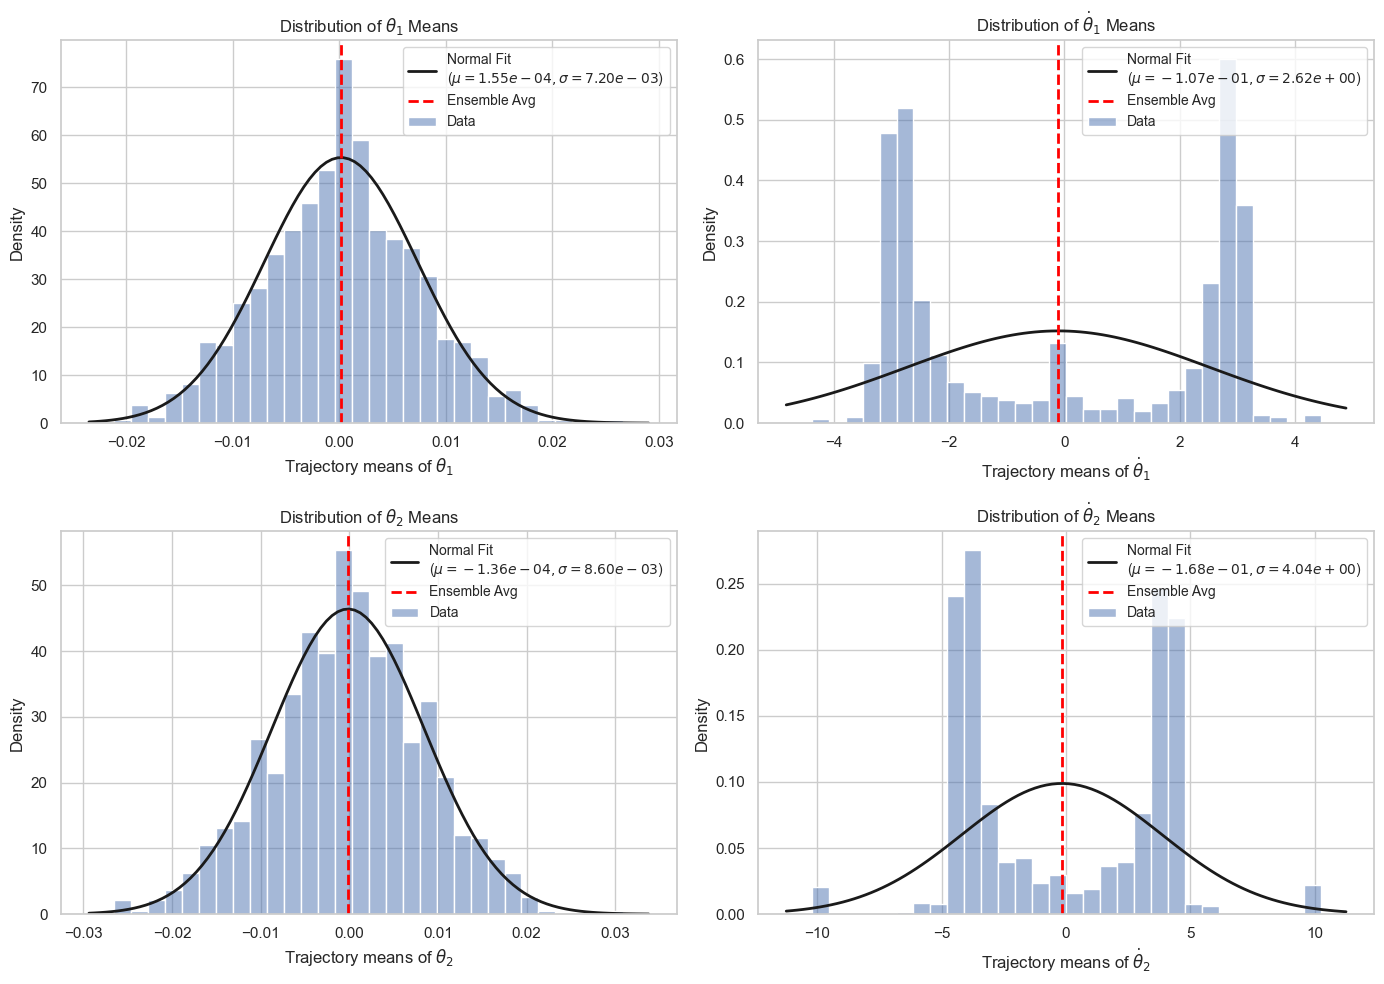

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# Configuration for the 4 variables: (Index, Label)
variables = [
    (0, r"$\theta_1$"),
    (1, r"$\dot{\theta}_1$"),
    (2, r"$\theta_2$"),
    (3, r"$\dot{\theta}_2$")
]

sns.set(style="whitegrid")

# Create a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # Flatten to make iteration easier (0 to 3)

for k, (col_idx, label) in enumerate(variables):
    ax = axes[k]
    
    # 1. Calculate trajectory means (the data points for the histogram)
    traj_means = [np.mean(traj[:, col_idx]) for traj in arrays]
    
    # 2. Calculate global ensemble mean (for the red line)
    all_data = np.concatenate([traj[:, col_idx] for traj in arrays])
    ens_mean = np.mean(all_data)
    
    # 3. Plot Histogram (stat="density" normalizes it so we can overlay the curve)
    sns.histplot(traj_means, bins=30, kde=False, stat="density", ax=ax, alpha=0.5, label="Data")
    
    # 4. Fit and Plot Normal Distribution
    # Get mean and std dev of the *means* distribution
    mu, std = norm.fit(traj_means) 
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    
    ax.plot(x, p, 'k-', linewidth=2, label=f"Normal Fit\n($\mu={mu:.2e}, \sigma={std:.2e}$)")
    
    # 5. Plot Ensemble Average Line
    ax.axvline(ens_mean, color="red", linestyle="--", linewidth=2, label=f"Ensemble Avg")
    
    # 6. Formatting
    ax.set_xlabel(f"Trajectory means of {label}")
    ax.set_ylabel("Density")
    ax.set_title(f"Distribution of {label} Means")
    ax.legend(loc='best', fontsize='small')

plt.tight_layout()
plt.show()

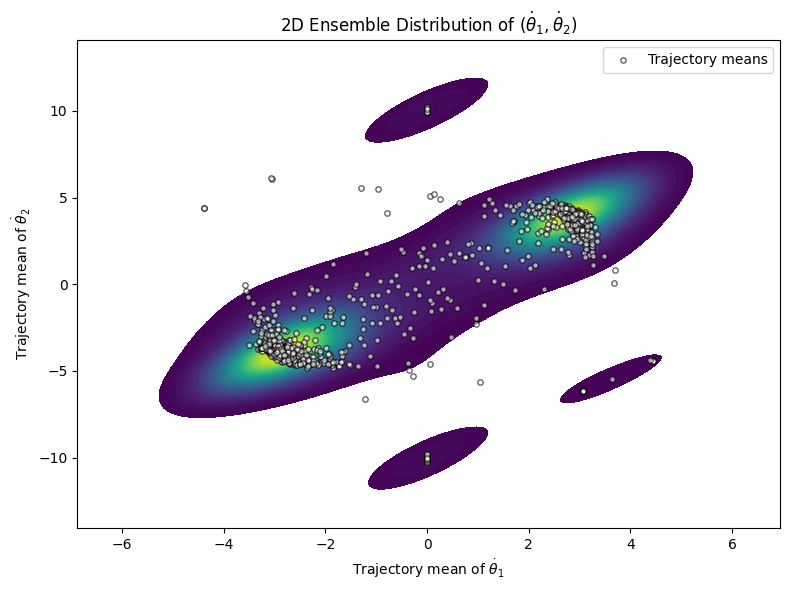

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Compute trajectory means for theta1_dot and theta2_dot
theta1_dot_means = np.array([np.mean(traj[:, 1]) for traj in arrays])
theta2_dot_means = np.array([np.mean(traj[:, 3]) for traj in arrays])

# 2. Create figure
plt.figure(figsize=(8, 6))

# 3. 2D KDE (density estimate)
sns.kdeplot(
    x=theta1_dot_means,
    y=theta2_dot_means,
    fill=True,
    levels=30,
    cmap="viridis",
    thresh=0.05
)

# 4. Overlay raw ensemble points
plt.scatter(
    theta1_dot_means,
    theta2_dot_means,
    s=15,
    c="white",
    edgecolor="black",
    alpha=0.6,
    label="Trajectory means"
)

# 5. Formatting
plt.xlabel(r"Trajectory mean of $\dot{\theta}_1$")
plt.ylabel(r"Trajectory mean of $\dot{\theta}_2$")
plt.title(r"2D Ensemble Distribution of $(\dot{\theta}_1, \dot{\theta}_2)$")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Identify representative trajectories from the two largest modes

import numpy as np
from sklearn.cluster import KMeans

# 1. Trajectory means (already conceptually used in your plot)
theta1_dot_means = np.array([np.mean(traj[:, 1]) for traj in arrays])
theta2_dot_means = np.array([np.mean(traj[:, 3]) for traj in arrays])

X = np.column_stack([theta1_dot_means, theta2_dot_means])

# 2. KMeans with 2 clusters (two dominant modes)
kmeans = KMeans(n_clusters=2, n_init=20, random_state=0)
labels = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_

# 3. For each cluster, find the two closest trajectories to the center
mode_indices = {}

for k in range(2):
    cluster_idx = np.where(labels == k)[0]
    cluster_points = X[cluster_idx]
    center = centers[k]

    # Euclidean distance to cluster center
    distances = np.linalg.norm(cluster_points - center, axis=1)

    # Indices of the two closest trajectories (global indices!)
    closest_two = cluster_idx[np.argsort(distances)[:2]]
    mode_indices[k] = closest_two

# 4. Print results
for k, idxs in mode_indices.items():
    print(f"Mode {k + 1}: trajectory indices {idxs}")
    print("  Means:")
    for i in idxs:
        print(f"    traj {i}: (theta1_dot = {theta1_dot_means[i]:.3f}, theta2_dot = {theta2_dot_means[i]:.3f})")


Mode 1: trajectory indices [823 101]
  Means:
    traj 823: (θ̇1̄ = -2.351, θ̇2̄ = -3.737)
    traj 101: (θ̇1̄ = -2.227, θ̇2̄ = -3.737)
Mode 2: trajectory indices [ 66 378]
  Means:
    traj 66: (θ̇1̄ = 2.375, θ̇2̄ = 3.871)
    traj 378: (θ̇1̄ = 2.453, θ̇2̄ = 3.920)


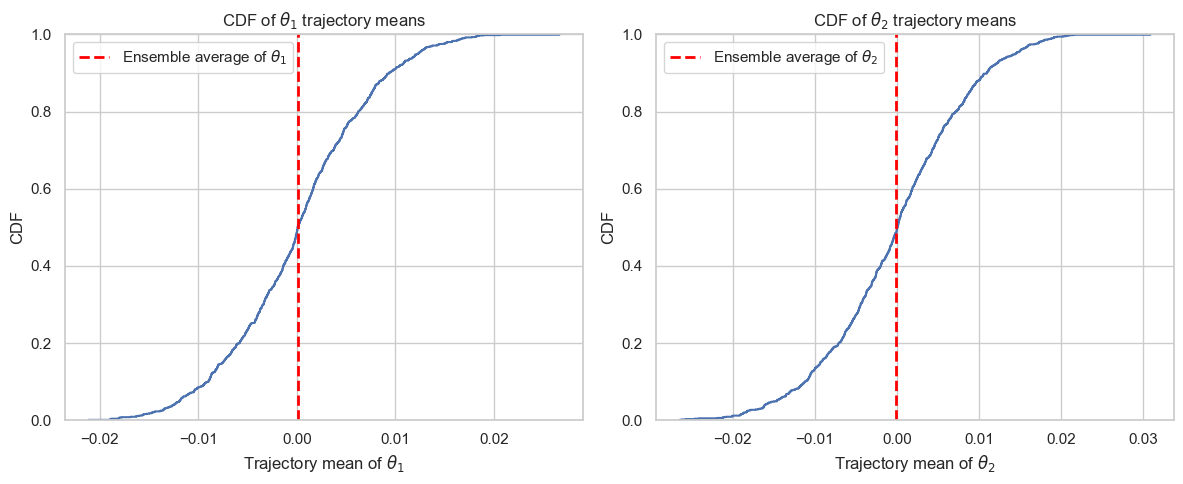

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left: CDF of theta1 means ---
sns.ecdfplot(theta1_means, ax=axes[0])
axes[0].axvline(theta1_ens_mean, color="red", linestyle="--", linewidth=2, label=r"Ensemble average of $\theta_1$")
axes[0].set_xlabel(r"Trajectory mean of $\theta_1$")
axes[0].set_ylabel("CDF")
axes[0].set_title(r"CDF of $\theta_1$ trajectory means")
axes[0].legend()

# --- Right: CDF of theta2 means ---
sns.ecdfplot(theta2_means, ax=axes[1])
axes[1].axvline(theta2_ens_mean, color="red", linestyle="--", linewidth=2, label=r"Ensemble average of $\theta_2$")
axes[1].set_xlabel(r"Trajectory mean of $\theta_2$")
axes[1].set_ylabel("CDF")
axes[1].set_title(r"CDF of $\theta_2$ trajectory means")
axes[1].legend()

plt.tight_layout()
plt.show()


## Distribution of $\cos(\theta_1)$ and $\cos(\theta_2)$ Means

In [17]:
theta1_cos_means = [np.mean(np.cos(traj[:, 0])) for traj in arrays] 
theta2_cos_means = [np.mean(np.cos(traj[:, 2])) for traj in arrays]

theta1_cos_all = np.concatenate([np.cos(traj[:, 0]) for traj in arrays])
theta2_cos_all = np.concatenate([np.cos(traj[:, 2]) for traj in arrays])

theta1_cos_ens_mean = np.mean(theta1_cos_all)
theta2_cos_ens_mean = np.mean(theta2_cos_all)


<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\s'
/var/folders/84/zf0g09hn7t7696hbkn6tcyk80000gn/T/ipykernel_35418/2684436209.py:18: SyntaxWarning: invalid escape sequence '\m'
  label=f'Fitted Normal\n($\mu={mu1:.2e}, \sigma={std1:.2e}$)')
/var/folders/84/zf0g09hn7t7696hbkn6tcyk80000gn/T/ipykernel_35418/2684436209.py:18: SyntaxWarning: invalid escape sequence '\s'
  label=f'Fitted Normal\n($\mu={mu1:.2e}, \sigma={std1:.2e}$)')
/var/folders/84/zf0g09hn7t7696hbkn6tcyk80000gn/T/ipykernel_35418/2684436209.py:33: SyntaxWarning: invalid escape sequence '\m'
  label=f'Fitted Normal\n($\mu={mu2:.2e}, \sigma={std2:.2e}$)')
/var/folders/84/zf0

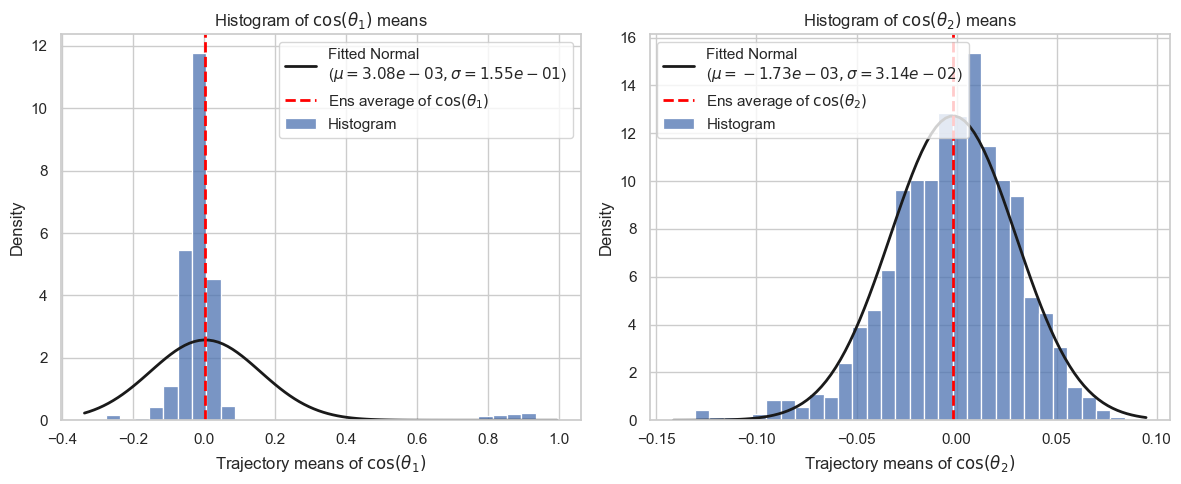

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

mu1, std1 = norm.fit(theta1_cos_means)

sns.histplot(theta1_cos_means, bins=30, kde=False, stat="density", ax=axes[0], 
             label="Histogram")
xmin1, xmax1 = axes[0].get_xlim()
x1 = np.linspace(xmin1, xmax1, 100)
p1 = norm.pdf(x1, mu1, std1)
axes[0].plot(x1, p1, 'k', linestyle="-", linewidth=2, 
             label=f'Fitted Normal\n($\mu={mu1:.2e}, \sigma={std1:.2e}$)')
axes[0].axvline(theta1_cos_ens_mean, color="red", linestyle="--", linewidth=2, 
                label=r"Ens average of $\cos(\theta_1)$")
axes[0].set_xlabel(r"Trajectory means of $\cos(\theta_1)$")
axes[0].set_ylabel("Density") 
axes[0].set_title(r"Histogram of $\cos(\theta_1)$ means")
axes[0].legend()

mu2, std2 = norm.fit(theta2_cos_means)
sns.histplot(theta2_cos_means, bins=30, kde=False, stat="density", ax=axes[1], 
             label="Histogram")
xmin2, xmax2 = axes[1].get_xlim()
x2 = np.linspace(xmin2, xmax2, 100)
p2 = norm.pdf(x2, mu2, std2)
axes[1].plot(x2, p2, 'k', linestyle="-", linewidth=2, 
             label=f'Fitted Normal\n($\mu={mu2:.2e}, \sigma={std2:.2e}$)')
axes[1].axvline(theta2_cos_ens_mean, color="red", linestyle="--", linewidth=2, 
                label=r"Ens average of $\cos(\theta_2)$")
axes[1].set_xlabel(r"Trajectory means of $\cos(\theta_2)$")
axes[1].set_ylabel("Density") 
axes[1].set_title(r"Histogram of $\cos(\theta_2)$ means")
axes[1].legend()

plt.tight_layout()
plt.show()

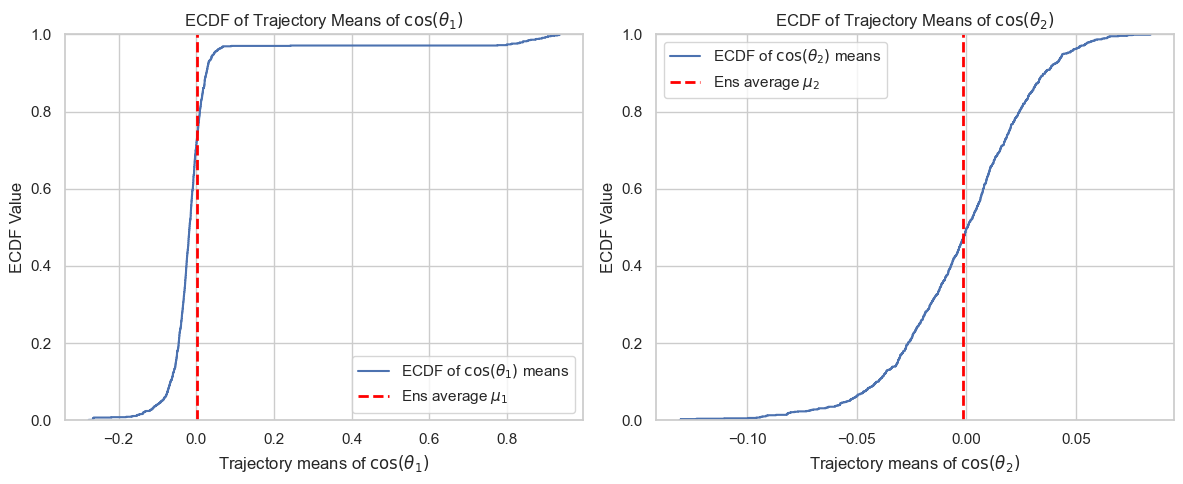

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set(style="whitegrid") # Already set in the previous cell if you're running interactively

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left: theta1 means ECDF ---
sns.ecdfplot(theta1_cos_means, ax=axes[0], label=r"ECDF of $\cos(\theta_1)$ means")
axes[0].axvline(theta1_cos_ens_mean, color="red", linestyle="--", linewidth=2, 
                label=r"Ens average $\mu_1$")
axes[0].set_xlabel(r"Trajectory means of $\cos(\theta_1)$")
axes[0].set_ylabel("ECDF Value")
axes[0].set_title(r"ECDF of Trajectory Means of $\cos(\theta_1)$")
axes[0].legend()

# --- Right: theta2 means ECDF ---
sns.ecdfplot(theta2_cos_means, ax=axes[1], label=r"ECDF of $\cos(\theta_2)$ means")
axes[1].axvline(theta2_cos_ens_mean, color="red", linestyle="--", linewidth=2, 
                label=r"Ens average $\mu_2$")
axes[1].set_xlabel(r"Trajectory means of $\cos(\theta_2)$")
axes[1].set_ylabel("ECDF Value")
axes[1].set_title(r"ECDF of Trajectory Means of $\cos(\theta_2)$")
axes[1].legend()

plt.tight_layout()
plt.show()